In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dtaidistance import dtw
import itertools
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import numpy as np

import random

from SVM_models.models import evaluate_binary_SVM_standard, evaluate_binary_SVM_custom

# import GunPoint dataset from GunPoint/GunPoint_test.txt and GunPoint/GunPoint_train.txt


def load_dataset(file_path):
    with open(file_path) as f:
        lines = f.readlines()
    # Parse each line, separating the label and features
    labels = []
    features = []
    for line in lines:
        values = list(map(float, line.strip().split()))
        labels.append(int(values[0])-1)  # First value is the label, cast to int
        features.append(values[1:])    # Remaining values are features
    # Convert lists to numpy arrays for easier handling
    labels = np.array(labels)
    features = np.array(features)
    # normalize dataset to 0 1
    features = (features - features.min()) / (features.max() - features.min())
    return labels, features

# Load the GunPoint dataset
train_labels, train_features = load_dataset("GunPoint/GunPoint_train.txt")
test_labels, test_features = load_dataset("GunPoint/GunPoint_test.txt")

#select only 30% of the data
#train_labels = train_labels[:int(len(train_labels)*0.3)]
#train_features = train_features[:int(len(train_features)*0.3)]

test_labels = test_labels[:int(len(test_labels)*0.2)]
test_features = test_features[:int(len(test_features)*0.2)]

print(train_labels.shape, train_features.shape)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\39331\anaconda3\envs\QtKernel_x_AD\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\39331\anaconda3\envs\QtKernel_x_AD\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\39331\anaconda3\envs\QtKernel_x_AD\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

(50,) (50, 150)


Text(0, 0.5, 'Feature Value')

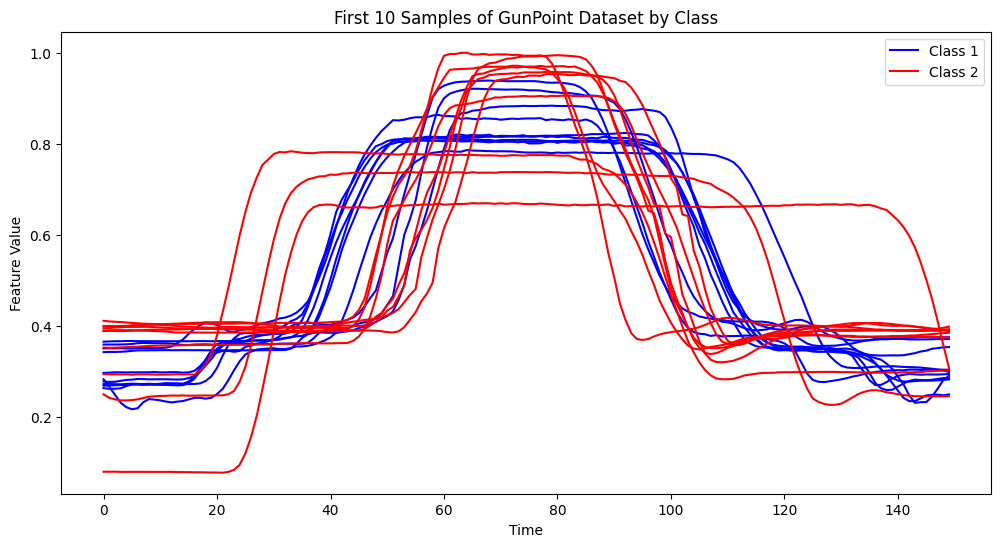

In [2]:


num_samples = 10

# Find indices of the first 10 samples for each class
class_1_indices = [i for i, label in enumerate(train_labels) if label == 0][:num_samples]
class_2_indices = [i for i, label in enumerate(train_labels) if label == 1][:num_samples]

# Plot samples for Class 1
plt.figure(figsize=(12, 6))
for idx in class_1_indices:
    plt.plot(train_features[idx], label="Class 1" if idx == class_1_indices[0] else "", color="blue")

# Plot samples for Class 2
for idx in class_2_indices:
    plt.plot(train_features[idx], label="Class 2" if idx == class_2_indices[0] else "", color="red")

# Add legend and title
plt.legend()
plt.title("First 10 Samples of GunPoint Dataset by Class")
plt.xlabel("Time")
plt.ylabel("Feature Value")
#plt.show()

In [3]:
from SVM_models.QuantumSVM import QuantumSVM

quantum_svm = QuantumSVM(n_qubits=2, sparsity_coefficient=0.99, embedding='sincos')

# Fit the model
quantum_svm.fit(train_features, train_labels)

# Predict on the test set
y_pred_on_train = quantum_svm.predict_on_train()

y_pred = quantum_svm.predict(test_features)

# Evaluate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(train_labels, y_pred_on_train)
print(f"Train Accuracy: {train_accuracy}")
accuracy = accuracy_score(test_labels, y_pred)
print(f"Test Accuracy: {accuracy}")


Building TEST_KERNEL: 100%|██████████| 1500/1500 [01:27<00:00, 17.18it/s]

Train Accuracy: 0.86
Test Accuracy: 0.7666666666666667


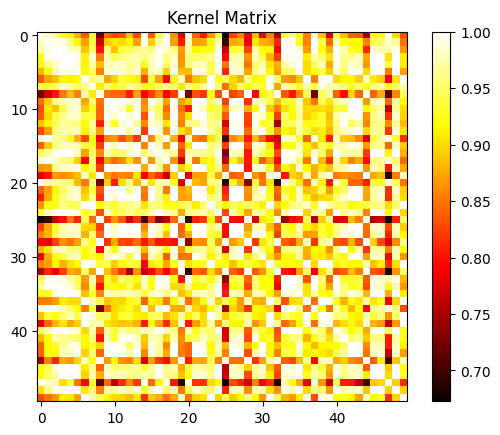

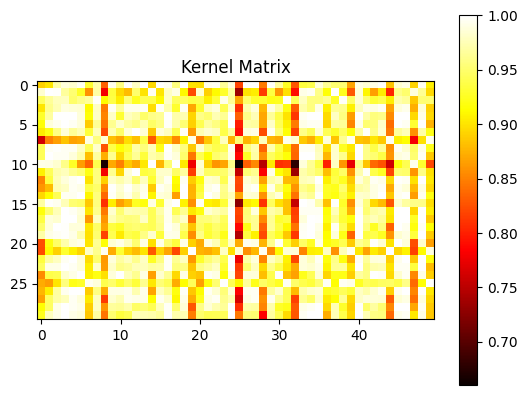

In [4]:
quantum_svm.print_as_heatmap(quantum_svm.K_train)
quantum_svm.print_as_heatmap(quantum_svm.K_test)

# Sperimentando

In [5]:
I = np.array([[1, 0], [0, 1]])  # Identity
X = np.array([[0, 1], [1, 0]])  # Pauli-X
Y = np.array([[0, -1j], [1j, 0]])  # Pauli-Y
Z = np.array([[1, 0], [0, -1]]) 

In [6]:
n_qubits = 2
coefficients = np.random.rand(4**n_qubits)

def generate_random_H_from_C(coefficients):
    """Generates a random Hamiltonian for the given number of qubits by combining Pauli matrices."""
    pauli_matrices = [I, X, Y, Z]  # Random coefficients for each term
    H = None
    # Generate all possible combinations of Pauli matrices for the given number of qubits
    for i in range(4**n_qubits):
        indices = np.unravel_index(i, (4,) * n_qubits)
        kron_product = pauli_matrices[indices[0]]
        for idx in indices[1:]:
            kron_product = np.kron(kron_product, pauli_matrices[idx])
        kron_product = np.array(kron_product, dtype=complex)
        if H is None:
            H = coefficients[i] * kron_product
        else:
            H += coefficients[i] * kron_product
    H = H / np.linalg.norm(H)  # Normalize the Hamiltonian
    return H

def ReLu_sparsity(W, s):
    """Applies ReLu sparsity to the given matrix W."""
    W = np.maximum(W-s, 0)/(1-s)  # Apply ReLu
    return W


my_H = generate_random_H_from_C(coefficients)

In [7]:
from bayes_opt import BayesianOptimization
import numpy as np
from sklearn.metrics import accuracy_score
from SVM_models.QuantumSVM import QuantumSVM

L = 150

# Define the number of qubits
n_qubits = 2
sparsity_coefficient=0.99
w =  np.random.rand(L)


# Define the objective function for Bayesian Optimization
def objective_function(**kwargs):
    # Convert kwargs to a coefficient array
    coefficients = np.array([kwargs[f"coeff_{i}"] for i in range(4**n_qubits)])
    w = np.array([kwargs[f"w_{i}"] for i in range(L)])
    w = ReLu_sparsity(w, sparsity_coefficient)

    # Generate the Hamiltonian
    my_H = generate_random_H_from_C(coefficients)
    
    # Fit the QuantumSVM model with the generated Hamiltonian
    quantum_svm = QuantumSVM(n_qubits=n_qubits, H=my_H, weights=w, embedding="euler")
    quantum_svm.fit(train_features, train_labels)
    
    # Predict on the test set and calculate the accuracy
    y_pred_on_train = quantum_svm.predict_on_train()
    train_accuracy = accuracy_score(train_labels, y_pred_on_train)
    y_pred = quantum_svm.predict(test_features)
    test_accuracy = accuracy_score(test_labels, y_pred)
    print(f"Test Accuracy: {test_accuracy}")
    
    # We aim to maximize this accuracy
    return train_accuracy

# Set bounds for each coefficient, assuming the coefficients range from 0 to 1
pbounds = {f"coeff_{i}": (0, 1) for i in range(4**n_qubits)}
pbounds.update({f"w_{i}": (0, 1) for i in range(L)})

# Initialize Bayesian Optimizer
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# Run optimization
optimizer.maximize(
    init_points=5,  # Number of random initial points
    n_iter=25        # Number of optimization steps
)

# Retrieve the best coefficients
best_coefficients = [optimizer.max["params"][f"coeff_{i}"] for i in range(4**n_qubits)]

print("Best Coefficients:", best_coefficients)
print("Best Test Accuracy:", optimizer.max["target"])


|   iter    |  target   |  coeff_0  |  coeff_1  | coeff_10  | coeff_11  | coeff_12  | coeff_13  | coeff_14  | coeff_15  |  coeff_2  |  coeff_3  |  coeff_4  |  coeff_5  |  coeff_6  |  coeff_7  |  coeff_8  |  coeff_9  |    w_0    |    w_1    |   w_10    |   w_100   |   w_101   |   w_102   |   w_103   |   w_104   |   w_105   |   w_106   |   w_107   |   w_108   |   w_109   |   w_11    |   w_110   |   w_111   |   w_112   |   w_113   |   w_114   |   w_115   |   w_116   |   w_117   |   w_118   |   w_119   |   w_12    |   w_120   |   w_121   |   w_122   |   w_123   |   w_124   |   w_125   |   w_126   |   w_127   |   w_128   |   w_129   |   w_13    |   w_130   |   w_131   |   w_132   |   w_133   |   w_134   |   w_135   |   w_136   |   w_137   |   w_138   |   w_139   |   w_14    |   w_140   |   w_141   |   w_142   |   w_143   |   w_144   |   w_145   |   w_146   |   w_147   |   w_148   |   w_149   |   w_15    |   w_16    |   w_17    |   w_18    |   w_19    |    w_2    |   w_20    |   w_21    |   

Building TEST_KERNEL: 100%|██████████| 1500/1500 [00:00<00:00, 20437.75it/s]


Test Accuracy: 0.4
| 1         | 0.52      | 0.3745    | 0.9507    | 0.732     | 0.5987    | 0.156     | 0.156     | 0.05808   | 0.8662    | 0.6011    | 0.7081    | 0.02058   | 0.9699    | 0.8324    | 0.2123    | 0.1818    | 0.1834    | 0.3042    | 0.5248    | 0.4319    | 0.2912    | 0.6119    | 0.1395    | 0.2921    | 0.3664    | 0.4561    | 0.7852    | 0.1997    | 0.5142    | 0.5924    | 0.04645   | 0.6075    | 0.1705    | 0.06505   | 0.9489    | 0.9656    | 0.8084    | 0.3046    | 0.09767   | 0.6842    | 0.4402    | 0.122     | 0.4952    | 0.03439   | 0.9093    | 0.2588    | 0.6625    | 0.3117    | 0.5201    | 0.5467    | 0.1849    | 0.9696    | 0.7751    | 0.9395    | 0.8948    | 0.5979    | 0.9219    | 0.08849   | 0.196     | 0.04523   | 0.3253    | 0.3887    | 0.2713    | 0.8287    | 0.3568    | 0.2809    | 0.5427    | 0.1409    | 0.8022    | 0.07455   | 0.9869    | 0.7722    | 0.1987    | 0.005522  | 0.8155    | 0.7069    | 0.729     | 0.7713    | 0.07404   | 0.3585    | 0.1159 

Building TEST_KERNEL: 100%|██████████| 1500/1500 [00:16<00:00, 91.06it/s] 


Test Accuracy: 0.4
| 2         | 0.52      | 0.3208    | 0.1865    | 0.04078   | 0.5909    | 0.6776    | 0.01659   | 0.5121    | 0.2265    | 0.6452    | 0.1744    | 0.6909    | 0.3867    | 0.9367    | 0.1375    | 0.3411    | 0.1135    | 0.9247    | 0.8773    | 0.2579    | 0.66      | 0.8172    | 0.5552    | 0.5297    | 0.2419    | 0.0931    | 0.8972    | 0.9004    | 0.6331    | 0.339     | 0.3492    | 0.726     | 0.8971    | 0.8871    | 0.7799    | 0.642     | 0.08414   | 0.1616    | 0.8986    | 0.6064    | 0.009197  | 0.1015    | 0.6635    | 0.005062  | 0.1608    | 0.5487    | 0.6919    | 0.652     | 0.2243    | 0.7122    | 0.2372    | 0.3254    | 0.7465    | 0.6496    | 0.8492    | 0.6576    | 0.5683    | 0.09367   | 0.3677    | 0.2652    | 0.244     | 0.973     | 0.3931    | 0.892     | 0.6311    | 0.7948    | 0.5026    | 0.5769    | 0.4925    | 0.1952    | 0.7225    | 0.2808    | 0.02432   | 0.6455    | 0.1771    | 0.9405    | 0.9539    | 0.9149    | 0.3702    | 0.01546   | 0.9283 

Building TEST_KERNEL: 100%|██████████| 1500/1500 [01:38<00:00, 15.18it/s]


Test Accuracy: 0.4
| 3         | 0.52      | 0.01439   | 0.1161    | 0.046     | 0.04073   | 0.8555    | 0.7037    | 0.4742    | 0.09783   | 0.4916    | 0.4735    | 0.1732    | 0.4339    | 0.3985    | 0.6159    | 0.6351    | 0.0453    | 0.3746    | 0.6259    | 0.5031    | 0.8565    | 0.6587    | 0.1629    | 0.07057   | 0.6424    | 0.02651   | 0.5858    | 0.9402    | 0.5755    | 0.3882    | 0.6433    | 0.4583    | 0.5456    | 0.9415    | 0.3861    | 0.9612    | 0.9054    | 0.1958    | 0.06936   | 0.1008    | 0.01822   | 0.09444   | 0.683     | 0.07119   | 0.319     | 0.8449    | 0.02327   | 0.8145    | 0.2819    | 0.1182    | 0.6967    | 0.6289    | 0.8775    | 0.7351    | 0.8035    | 0.282     | 0.1774    | 0.7506    | 0.8068    | 0.9905    | 0.4126    | 0.372     | 0.7764    | 0.3408    | 0.9308    | 0.8584    | 0.429     | 0.7509    | 0.7545    | 0.1031    | 0.9026    | 0.5053    | 0.8265    | 0.32      | 0.8955    | 0.3892    | 0.01084   | 0.9054    | 0.09129   | 0.3193    | 0.9501 

Building TEST_KERNEL: 100%|██████████| 1500/1500 [01:14<00:00, 20.03it/s]


Test Accuracy: 0.6666666666666666
| 4         | 0.66      | 0.9744    | 0.9862    | 0.6982    | 0.5361    | 0.3095    | 0.8138    | 0.6847    | 0.1626    | 0.9109    | 0.8225    | 0.9498    | 0.7257    | 0.6134    | 0.4182    | 0.9327    | 0.8661    | 0.04522   | 0.02637   | 0.3765    | 0.8106    | 0.9873    | 0.1504    | 0.5941    | 0.3809    | 0.9699    | 0.8421    | 0.8383    | 0.4687    | 0.4148    | 0.2734    | 0.05638   | 0.8647    | 0.8129    | 0.9997    | 0.9966    | 0.5554    | 0.769     | 0.9448    | 0.8496    | 0.2473    | 0.4505    | 0.1292    | 0.9541    | 0.6062    | 0.2286    | 0.6717    | 0.6181    | 0.3582    | 0.1136    | 0.6716    | 0.5203    | 0.7723    | 0.5202    | 0.8522    | 0.5519    | 0.5609    | 0.8767    | 0.4035    | 0.134     | 0.02878   | 0.7551    | 0.6203    | 0.7041    | 0.213     | 0.1364    | 0.01454   | 0.3506    | 0.5899    | 0.3922    | 0.4375    | 0.9042    | 0.3483    | 0.514     | 0.7837    | 0.3965    | 0.6221    | 0.8624    | 0.9495    | 0.14

Building TEST_KERNEL: 100%|██████████| 1500/1500 [00:00<00:00, 20530.73it/s]

Test Accuracy: 0.4
| 5         | 0.52      | 0.1018    | 0.1529    | 0.246     | 0.1607    | 0.1866    | 0.2851    | 0.1734    | 0.8968    | 0.08023   | 0.5245    | 0.4104    | 0.9824    | 0.112     | 0.3979    | 0.9695    | 0.8655    | 0.8171    | 0.2579    | 0.1709    | 0.6686    | 0.9294    | 0.5568    | 0.5716    | 0.28      | 0.7695    | 0.187     | 0.3237    | 0.4254    | 0.5076    | 0.2424    | 0.1148    | 0.6106    | 0.2886    | 0.5812    | 0.1544    | 0.4811    | 0.5326    | 0.05182   | 0.3366    | 0.1344    | 0.06337   | 0.99      | 0.3224    | 0.8099    | 0.2546    | 0.6815    | 0.7602    | 0.5956    | 0.4716    | 0.4118    | 0.3489    | 0.9295    | 0.8306    | 0.965     | 0.1243    | 0.7309    | 0.9383    | 0.1812    | 0.0665    | 0.7411    | 0.5745    | 0.8418    | 0.1398    | 0.7953    | 0.2016    | 0.1637    | 0.1643    | 0.8146    | 0.6652    | 0.5231    | 0.3588    | 0.8772    | 0.3924    | 0.8166    | 0.4391    | 0.3769    | 0.4627    | 0.3014    | 0.7476    | 0.5027 


Building TEST_KERNEL: 100%|██████████| 1500/1500 [00:00<00:00, 16401.04it/s]


Test Accuracy: 0.4
| 6         | 0.52      | 0.3976    | 0.766     | 0.842     | 0.05277   | 0.2293    | 0.3499    | 0.08251   | 0.6268    | 0.9824    | 0.4058    | 0.2119    | 0.8638    | 0.2836    | 0.2229    | 0.542     | 0.2906    | 0.399     | 0.5593    | 0.6119    | 0.4161    | 0.1932    | 0.4124    | 0.7105    | 0.8133    | 0.5165    | 0.272     | 0.2586    | 0.01053   | 0.3576    | 0.03453   | 0.2971    | 0.7144    | 0.07514   | 0.9022    | 0.7372    | 0.8992    | 0.1545    | 0.1003    | 0.03666   | 0.4078    | 0.05207   | 0.8399    | 0.3237    | 0.05172   | 0.4393    | 0.7149    | 0.3525    | 0.1393    | 0.9797    | 0.2736    | 0.5991    | 0.03845   | 0.02493   | 0.4358    | 0.262     | 0.8135    | 0.6371    | 0.1784    | 0.1415    | 0.03668   | 0.2836    | 0.7848    | 0.5112    | 0.3381    | 0.1602    | 0.1875    | 0.07179   | 0.1336    | 0.2412    | 0.6699    | 0.5977    | 0.129     | 0.7718    | 0.5831    | 0.2365    | 0.4173    | 0.4167    | 0.7469    | 0.5778    | 0.9581 

Building TEST_KERNEL: 100%|██████████| 1500/1500 [01:06<00:00, 22.67it/s]


Test Accuracy: 0.5
| 7         | 0.84      | 0.7063    | 0.5024    | 0.3369    | 0.07861   | 0.09658   | 0.8371    | 0.4013    | 0.4417    | 0.8251    | 0.327     | 0.1952    | 0.2613    | 0.6226    | 0.855     | 0.4426    | 0.9132    | 0.5386    | 0.05626   | 0.09303   | 0.8516    | 0.6258    | 0.246     | 0.5084    | 0.2299    | 0.9449    | 0.6284    | 0.3889    | 0.4863    | 0.2423    | 0.1323    | 0.6118    | 0.7361    | 0.9761    | 0.8968    | 0.07228   | 0.5579    | 0.2828    | 0.9083    | 0.2149    | 0.9268    | 0.6512    | 0.3847    | 0.9762    | 0.2276    | 0.4985    | 0.3147    | 0.8184    | 0.3532    | 0.606     | 0.8894    | 0.7475    | 0.8762    | 0.647     | 0.4135    | 0.5751    | 0.1722    | 0.9065    | 0.321     | 0.6091    | 0.124     | 0.8037    | 0.4827    | 0.6447    | 0.1442    | 0.7995    | 0.4253    | 0.9577    | 0.1482    | 0.3075    | 0.1328    | 0.7832    | 0.2231    | 0.6059    | 0.5758    | 0.9348    | 0.7001    | 0.7094    | 0.01262   | 0.4794    | 0.1818 

Building TEST_KERNEL: 100%|██████████| 1500/1500 [01:03<00:00, 23.58it/s]


Test Accuracy: 0.7666666666666667
| 8         | 0.8       | 0.7967    | 0.6165    | 0.4152    | 0.1675    | 0.1263    | 0.8708    | 0.4757    | 0.3686    | 0.8633    | 0.4302    | 0.3555    | 0.3328    | 0.6296    | 0.7946    | 0.5444    | 0.9392    | 0.4221    | 0.01156   | 0.1387    | 0.861     | 0.7048    | 0.2137    | 0.5282    | 0.2495    | 0.9847    | 0.684     | 0.4826    | 0.487     | 0.2685    | 0.1573    | 0.5001    | 0.7725    | 0.9798    | 0.9305    | 0.244     | 0.5559    | 0.3915    | 0.959     | 0.3475    | 0.823     | 0.6439    | 0.3018    | 1.0       | 0.2977    | 0.4429    | 0.3743    | 0.789     | 0.3533    | 0.495     | 0.8769    | 0.711     | 0.8674    | 0.6205    | 0.4859    | 0.5841    | 0.2257    | 0.9247    | 0.3413    | 0.5278    | 0.08681   | 0.8101    | 0.5042    | 0.6656    | 0.1288    | 0.6765    | 0.3393    | 0.8653    | 0.2189    | 0.3271    | 0.1622    | 0.8314    | 0.2391    | 0.5951    | 0.6183    | 0.8394    | 0.6939    | 0.7473    | 0.2002    | 0.40

Building TEST_KERNEL: 100%|██████████| 1500/1500 [23:32<00:00,  1.06it/s]


Test Accuracy: 0.8333333333333334
| 9         | 0.94      | 1.0       | 0.5147    | 0.1743    | 0.0       | 0.0       | 1.0       | 0.5489    | 0.355     | 1.0       | 0.003009  | 0.0       | 0.0       | 0.8       | 1.0       | 0.1295    | 1.0       | 0.5708    | 0.0       | 0.0       | 1.0       | 0.472     | 0.007756  | 0.5593    | 0.0       | 1.0       | 0.7085    | 0.002223  | 0.5911    | 0.0       | 0.0       | 1.0       | 0.8949    | 1.0       | 1.0       | 0.0       | 0.5104    | 0.1638    | 1.0       | 0.0       | 1.0       | 1.0       | 0.0       | 1.0       | 0.0       | 0.6424    | 0.0       | 1.0       | 0.3719    | 0.7647    | 1.0       | 1.0       | 1.0       | 0.735     | 0.0       | 0.9014    | 0.0       | 1.0       | 0.2825    | 1.0       | 0.0       | 1.0       | 0.2191    | 0.7827    | 0.0       | 1.0       | 0.662     | 1.0       | 0.0       | 0.3404    | 0.0       | 1.0       | 0.0       | 0.8842    | 0.4485    | 1.0       | 1.0       | 0.6994    | 0.0       | 0.72

Building TEST_KERNEL:   1%|          | 8/1500 [00:16<51:15,  2.06s/it]


KeyboardInterrupt: 